# DPG for Cartpole


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.11.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [6]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.486000026364974 -2.9400261151707268
actions: 1 0
rewards: 1.0 1.0


In [7]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [8]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [9]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [30]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    training = tf.placeholder(tf.bool, [], name='training')
    return states, actions, targetQs, rates, training

In [31]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [32]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [33]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates, training):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size, training=training)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states, training=training)
    rates = tf.reshape(rates, shape=[-1, 1]) # [0, 1]
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                   labels=rates)) # 0-1
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, training=training, 
                        reuse=True)
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    return actions_logits, gQs, gloss, dloss

In [34]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
    return g_opt, d_opt

In [35]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates, self.training = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, 
            rates=self.rates, training=self.training) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss,
                                           g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

In [36]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [37]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [38]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [39]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [43]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1 # [-1, +1] or [0, 1]
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500 # [0, 1]
        total_reward = 0
        for idx in range(num_step):
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        num_step = 0

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [78]:
# batch = memory.buffer
def minibatch(batch):
    #for idx in range(memory_size// batch_size):
    #for idx in range(memory_size- batch_size + 1):
    #idx = np.random.choice(np.arange(memory_size- batch_size+ 1))
    idx = np.random.choice(np.arange(memory_size// batch_size))
    percentage = 0.9
    states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
    actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
    next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
    rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
    dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
    rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
    states = states[rates >= (np.max(rates)*percentage)]
    actions = actions[rates >= (np.max(rates)*percentage)]
    next_states = next_states[rates >= (np.max(rates)*percentage)]
    rewards = rewards[rates >= (np.max(rates)*percentage)]
    dones = dones[rates >= (np.max(rates)*percentage)]
    rates = rates[rates >= (np.max(rates)*percentage)]
    return states, actions, next_states, rewards, dones, rates

In [80]:
batch = memory.buffer
states, actions, next_states, rewards, dones, rates = minibatch(batch=batch)

In [81]:
states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape, \
states.dtype, actions.dtype, next_states.dtype, rewards.dtype, dones.dtype, rates.dtype

((61, 4),
 (61,),
 (61, 4),
 (61,),
 (61,),
 (61,),
 dtype('float64'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'))

In [82]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], [] # goal
gloss_list, dloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*2):
        total_reward = 0 # each episode
        gloss_batch, dloss_batch = [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1]), 
                                                                          model.training: False})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            rate = -1 # [-1, +1] or [0, 1]
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # memory incremented
            total_reward += reward
            state = next_state
            
            # Rating
            if done is True:
                rate = total_reward/500 # [0, 1]
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1:
                        memory.buffer[-1-idx][-1] = rate
                        
            # Training
            batch = memory.buffer
            states, actions, next_states, rewards, dones, rates = minibatch(batch=batch)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states,
                                                                   model.training: False})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dloss, _ = sess.run([model.d_loss, model.d_opt],feed_dict = {model.states: states, 
                                                                         model.actions: actions,
                                                                         model.targetQs: targetQs, 
                                                                         model.rates: rates,
                                                                         model.training: False})
            gloss, _ = sess.run([model.g_loss, model.g_opt],feed_dict = {model.states: states, 
                                                                         model.actions: actions,
                                                                         model.targetQs: targetQs, 
                                                                         model.rates: rates,
                                                                         model.training: False})
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:19.0000 R:19.0000 rate:0.0380 gloss:1.3662 dloss:1.3669 exploreP:0.9981
Episode:1 meanR:17.5000 R:16.0000 rate:0.0320 gloss:1.3648 dloss:1.3617 exploreP:0.9965
Episode:2 meanR:15.3333 R:11.0000 rate:0.0220 gloss:1.3627 dloss:1.3604 exploreP:0.9955
Episode:3 meanR:19.0000 R:30.0000 rate:0.0600 gloss:1.3672 dloss:1.3677 exploreP:0.9925
Episode:4 meanR:19.8000 R:23.0000 rate:0.0460 gloss:1.3659 dloss:1.3644 exploreP:0.9902
Episode:5 meanR:18.3333 R:11.0000 rate:0.0220 gloss:1.3670 dloss:1.3647 exploreP:0.9892
Episode:6 meanR:18.0000 R:16.0000 rate:0.0320 gloss:1.3655 dloss:1.3616 exploreP:0.9876
Episode:7 meanR:18.0000 R:18.0000 rate:0.0360 gloss:1.3664 dloss:1.3625 exploreP:0.9858
Episode:8 meanR:17.7778 R:16.0000 rate:0.0320 gloss:1.3654 dloss:1.3588 exploreP:0.9843
Episode:9 meanR:18.1000 R:21.0000 rate:0.0420 gloss:1.3654 dloss:1.3622 exploreP:0.9822
Episode:10 meanR:17.4545 R:11.0000 rate:0.0220 gloss:1.3664 dloss:1.3634 exploreP:0.9812
Episode:11 meanR:17.2500 R:15.0

Episode:93 meanR:19.4043 R:19.0000 rate:0.0380 gloss:1.3299 dloss:1.3299 exploreP:0.8349
Episode:94 meanR:19.3368 R:13.0000 rate:0.0260 gloss:1.3263 dloss:1.3263 exploreP:0.8339
Episode:95 meanR:19.3542 R:21.0000 rate:0.0420 gloss:1.3300 dloss:1.3304 exploreP:0.8321
Episode:96 meanR:19.6495 R:48.0000 rate:0.0960 gloss:1.3275 dloss:1.3281 exploreP:0.8282
Episode:97 meanR:19.6122 R:16.0000 rate:0.0320 gloss:1.3332 dloss:1.3333 exploreP:0.8269
Episode:98 meanR:19.4949 R:8.0000 rate:0.0160 gloss:1.3291 dloss:1.3290 exploreP:0.8262
Episode:99 meanR:19.5000 R:20.0000 rate:0.0400 gloss:1.3313 dloss:1.3315 exploreP:0.8246
Episode:100 meanR:19.6800 R:37.0000 rate:0.0740 gloss:1.3263 dloss:1.3266 exploreP:0.8216
Episode:101 meanR:19.7400 R:22.0000 rate:0.0440 gloss:1.3352 dloss:1.3349 exploreP:0.8198
Episode:102 meanR:19.7400 R:11.0000 rate:0.0220 gloss:1.3252 dloss:1.3256 exploreP:0.8189
Episode:103 meanR:19.5600 R:12.0000 rate:0.0240 gloss:1.3384 dloss:1.3382 exploreP:0.8180
Episode:104 meanR:

Episode:185 meanR:19.3800 R:20.0000 rate:0.0400 gloss:1.3360 dloss:1.3363 exploreP:0.7006
Episode:186 meanR:19.3700 R:11.0000 rate:0.0220 gloss:1.3294 dloss:1.3295 exploreP:0.6998
Episode:187 meanR:19.3900 R:20.0000 rate:0.0400 gloss:1.3324 dloss:1.3325 exploreP:0.6984
Episode:188 meanR:19.3000 R:29.0000 rate:0.0580 gloss:1.3310 dloss:1.3312 exploreP:0.6964
Episode:189 meanR:19.3000 R:12.0000 rate:0.0240 gloss:1.3334 dloss:1.3335 exploreP:0.6956
Episode:190 meanR:19.3300 R:14.0000 rate:0.0280 gloss:1.3306 dloss:1.3306 exploreP:0.6946
Episode:191 meanR:19.3100 R:29.0000 rate:0.0580 gloss:1.3280 dloss:1.3281 exploreP:0.6927
Episode:192 meanR:19.2300 R:11.0000 rate:0.0220 gloss:1.3300 dloss:1.3300 exploreP:0.6919
Episode:193 meanR:19.1600 R:12.0000 rate:0.0240 gloss:1.3273 dloss:1.3274 exploreP:0.6911
Episode:194 meanR:19.1100 R:8.0000 rate:0.0160 gloss:1.3328 dloss:1.3330 exploreP:0.6906
Episode:195 meanR:19.0100 R:11.0000 rate:0.0220 gloss:1.3370 dloss:1.3375 exploreP:0.6898
Episode:196

Episode:277 meanR:16.8200 R:15.0000 rate:0.0300 gloss:1.3248 dloss:1.3248 exploreP:0.6027
Episode:278 meanR:16.8500 R:17.0000 rate:0.0340 gloss:1.3214 dloss:1.3215 exploreP:0.6017
Episode:279 meanR:16.7900 R:14.0000 rate:0.0280 gloss:1.3285 dloss:1.3286 exploreP:0.6009
Episode:280 meanR:16.8200 R:12.0000 rate:0.0240 gloss:1.3210 dloss:1.3211 exploreP:0.6002
Episode:281 meanR:17.0500 R:41.0000 rate:0.0820 gloss:1.3263 dloss:1.3267 exploreP:0.5978
Episode:282 meanR:17.0200 R:13.0000 rate:0.0260 gloss:1.3304 dloss:1.3305 exploreP:0.5970
Episode:283 meanR:16.9600 R:29.0000 rate:0.0580 gloss:1.3301 dloss:1.3305 exploreP:0.5953
Episode:284 meanR:16.8500 R:11.0000 rate:0.0220 gloss:1.3335 dloss:1.3340 exploreP:0.5946
Episode:285 meanR:16.7700 R:12.0000 rate:0.0240 gloss:1.3320 dloss:1.3321 exploreP:0.5939
Episode:286 meanR:16.7600 R:10.0000 rate:0.0200 gloss:1.3237 dloss:1.3239 exploreP:0.5934
Episode:287 meanR:16.7000 R:14.0000 rate:0.0280 gloss:1.3309 dloss:1.3309 exploreP:0.5925
Episode:28

Episode:369 meanR:15.3100 R:19.0000 rate:0.0380 gloss:1.3299 dloss:1.3301 exploreP:0.5242
Episode:370 meanR:15.2800 R:10.0000 rate:0.0200 gloss:1.3287 dloss:1.3287 exploreP:0.5237
Episode:371 meanR:15.3300 R:15.0000 rate:0.0300 gloss:1.3320 dloss:1.3321 exploreP:0.5229
Episode:372 meanR:15.3800 R:16.0000 rate:0.0320 gloss:1.3317 dloss:1.3318 exploreP:0.5221
Episode:373 meanR:15.3000 R:10.0000 rate:0.0200 gloss:1.3340 dloss:1.3340 exploreP:0.5216
Episode:374 meanR:15.2500 R:9.0000 rate:0.0180 gloss:1.3369 dloss:1.3371 exploreP:0.5211
Episode:375 meanR:15.3900 R:27.0000 rate:0.0540 gloss:1.3354 dloss:1.3362 exploreP:0.5197
Episode:376 meanR:15.3700 R:14.0000 rate:0.0280 gloss:1.3328 dloss:1.3339 exploreP:0.5190
Episode:377 meanR:15.3300 R:11.0000 rate:0.0220 gloss:1.3332 dloss:1.3346 exploreP:0.5185
Episode:378 meanR:15.2700 R:11.0000 rate:0.0220 gloss:1.3346 dloss:1.3349 exploreP:0.5179
Episode:379 meanR:15.2900 R:16.0000 rate:0.0320 gloss:1.3328 dloss:1.3328 exploreP:0.5171
Episode:380

Episode:461 meanR:13.5700 R:12.0000 rate:0.0240 gloss:1.3274 dloss:1.3274 exploreP:0.4639
Episode:462 meanR:13.5600 R:12.0000 rate:0.0240 gloss:1.3252 dloss:1.3256 exploreP:0.4634
Episode:463 meanR:13.6100 R:16.0000 rate:0.0320 gloss:1.3265 dloss:1.3275 exploreP:0.4626
Episode:464 meanR:13.5900 R:10.0000 rate:0.0200 gloss:1.3261 dloss:1.3263 exploreP:0.4622
Episode:465 meanR:13.6500 R:21.0000 rate:0.0420 gloss:1.3251 dloss:1.3252 exploreP:0.4612
Episode:466 meanR:13.6300 R:10.0000 rate:0.0200 gloss:1.3275 dloss:1.3291 exploreP:0.4608
Episode:467 meanR:13.6100 R:13.0000 rate:0.0260 gloss:1.3359 dloss:1.3370 exploreP:0.4602
Episode:468 meanR:13.5700 R:9.0000 rate:0.0180 gloss:1.3247 dloss:1.3248 exploreP:0.4598
Episode:469 meanR:13.5200 R:14.0000 rate:0.0280 gloss:1.3314 dloss:1.3328 exploreP:0.4592
Episode:470 meanR:13.5100 R:9.0000 rate:0.0180 gloss:1.3335 dloss:1.3338 exploreP:0.4588
Episode:471 meanR:13.5000 R:14.0000 rate:0.0280 gloss:1.3360 dloss:1.3377 exploreP:0.4581
Episode:472 

Episode:553 meanR:13.0300 R:10.0000 rate:0.0200 gloss:1.3200 dloss:1.3201 exploreP:0.4123
Episode:554 meanR:13.0700 R:12.0000 rate:0.0240 gloss:1.3246 dloss:1.3246 exploreP:0.4118
Episode:555 meanR:13.0800 R:11.0000 rate:0.0220 gloss:1.3309 dloss:1.3310 exploreP:0.4114
Episode:556 meanR:13.0800 R:12.0000 rate:0.0240 gloss:1.3292 dloss:1.3294 exploreP:0.4109
Episode:557 meanR:13.0000 R:9.0000 rate:0.0180 gloss:1.3324 dloss:1.3323 exploreP:0.4105
Episode:558 meanR:13.0400 R:15.0000 rate:0.0300 gloss:1.3248 dloss:1.3249 exploreP:0.4099
Episode:559 meanR:13.0300 R:12.0000 rate:0.0240 gloss:1.3372 dloss:1.3388 exploreP:0.4095
Episode:560 meanR:13.0100 R:11.0000 rate:0.0220 gloss:1.3321 dloss:1.3323 exploreP:0.4090
Episode:561 meanR:12.9800 R:9.0000 rate:0.0180 gloss:1.3167 dloss:1.3169 exploreP:0.4087
Episode:562 meanR:12.9500 R:9.0000 rate:0.0180 gloss:1.3193 dloss:1.3194 exploreP:0.4083
Episode:563 meanR:12.8900 R:10.0000 rate:0.0200 gloss:1.3283 dloss:1.3287 exploreP:0.4079
Episode:564 m

Episode:645 meanR:11.8200 R:9.0000 rate:0.0180 gloss:1.3239 dloss:1.3241 exploreP:0.3711
Episode:646 meanR:11.8400 R:12.0000 rate:0.0240 gloss:1.3277 dloss:1.3279 exploreP:0.3707
Episode:647 meanR:11.8100 R:9.0000 rate:0.0180 gloss:1.3233 dloss:1.3234 exploreP:0.3704
Episode:648 meanR:11.8500 R:13.0000 rate:0.0260 gloss:1.3197 dloss:1.3198 exploreP:0.3699
Episode:649 meanR:11.8500 R:9.0000 rate:0.0180 gloss:1.3256 dloss:1.3256 exploreP:0.3696
Episode:650 meanR:11.7000 R:10.0000 rate:0.0200 gloss:1.3235 dloss:1.3237 exploreP:0.3692
Episode:651 meanR:11.6500 R:10.0000 rate:0.0200 gloss:1.3360 dloss:1.3362 exploreP:0.3689
Episode:652 meanR:11.6900 R:16.0000 rate:0.0320 gloss:1.3288 dloss:1.3289 exploreP:0.3683
Episode:653 meanR:11.6900 R:10.0000 rate:0.0200 gloss:1.3307 dloss:1.3310 exploreP:0.3679
Episode:654 meanR:11.6600 R:9.0000 rate:0.0180 gloss:1.3224 dloss:1.3225 exploreP:0.3676
Episode:655 meanR:11.7000 R:15.0000 rate:0.0300 gloss:1.3242 dloss:1.3246 exploreP:0.3671
Episode:656 me

Episode:737 meanR:12.2300 R:11.0000 rate:0.0220 gloss:1.3278 dloss:1.3280 exploreP:0.3330
Episode:738 meanR:12.2300 R:10.0000 rate:0.0200 gloss:1.3169 dloss:1.3172 exploreP:0.3327
Episode:739 meanR:12.1400 R:13.0000 rate:0.0260 gloss:1.3277 dloss:1.3290 exploreP:0.3323
Episode:740 meanR:12.1400 R:12.0000 rate:0.0240 gloss:1.3301 dloss:1.3301 exploreP:0.3319
Episode:741 meanR:12.1400 R:10.0000 rate:0.0200 gloss:1.3212 dloss:1.3214 exploreP:0.3316
Episode:742 meanR:12.0700 R:12.0000 rate:0.0240 gloss:1.3294 dloss:1.3298 exploreP:0.3312
Episode:743 meanR:12.0400 R:9.0000 rate:0.0180 gloss:1.3234 dloss:1.3237 exploreP:0.3309
Episode:744 meanR:12.0100 R:12.0000 rate:0.0240 gloss:1.3267 dloss:1.3270 exploreP:0.3305
Episode:745 meanR:12.0200 R:10.0000 rate:0.0200 gloss:1.3281 dloss:1.3282 exploreP:0.3302
Episode:746 meanR:12.0100 R:11.0000 rate:0.0220 gloss:1.3233 dloss:1.3235 exploreP:0.3299
Episode:747 meanR:12.0200 R:10.0000 rate:0.0200 gloss:1.3265 dloss:1.3266 exploreP:0.3295
Episode:748

Episode:829 meanR:11.7700 R:9.0000 rate:0.0180 gloss:1.3278 dloss:1.3284 exploreP:0.3000
Episode:830 meanR:11.7300 R:10.0000 rate:0.0200 gloss:1.3189 dloss:1.3193 exploreP:0.2997
Episode:831 meanR:11.6900 R:10.0000 rate:0.0200 gloss:1.3166 dloss:1.3167 exploreP:0.2995
Episode:832 meanR:11.7100 R:12.0000 rate:0.0240 gloss:1.3298 dloss:1.3299 exploreP:0.2991
Episode:833 meanR:11.7600 R:15.0000 rate:0.0300 gloss:1.3180 dloss:1.3184 exploreP:0.2987
Episode:834 meanR:11.6800 R:11.0000 rate:0.0220 gloss:1.3248 dloss:1.3252 exploreP:0.2984
Episode:835 meanR:11.6800 R:9.0000 rate:0.0180 gloss:1.3271 dloss:1.3270 exploreP:0.2981
Episode:836 meanR:11.6700 R:11.0000 rate:0.0220 gloss:1.3309 dloss:1.3310 exploreP:0.2978
Episode:837 meanR:11.6500 R:9.0000 rate:0.0180 gloss:1.3220 dloss:1.3221 exploreP:0.2975
Episode:838 meanR:11.6700 R:12.0000 rate:0.0240 gloss:1.3275 dloss:1.3275 exploreP:0.2972
Episode:839 meanR:11.6500 R:11.0000 rate:0.0220 gloss:1.3303 dloss:1.3308 exploreP:0.2969
Episode:840 m

Episode:921 meanR:11.0900 R:8.0000 rate:0.0160 gloss:1.3171 dloss:1.3173 exploreP:0.2721
Episode:922 meanR:11.0400 R:8.0000 rate:0.0160 gloss:1.3366 dloss:1.3412 exploreP:0.2719
Episode:923 meanR:11.0200 R:8.0000 rate:0.0160 gloss:1.3154 dloss:1.3158 exploreP:0.2717
Episode:924 meanR:10.9800 R:10.0000 rate:0.0200 gloss:1.3170 dloss:1.3173 exploreP:0.2715
Episode:925 meanR:10.9500 R:11.0000 rate:0.0220 gloss:1.3216 dloss:1.3218 exploreP:0.2712
Episode:926 meanR:10.8900 R:12.0000 rate:0.0240 gloss:1.3145 dloss:1.3147 exploreP:0.2709
Episode:927 meanR:10.9100 R:13.0000 rate:0.0260 gloss:1.3218 dloss:1.3235 exploreP:0.2705
Episode:928 meanR:10.9200 R:10.0000 rate:0.0200 gloss:1.3277 dloss:1.3279 exploreP:0.2703
Episode:929 meanR:10.9600 R:13.0000 rate:0.0260 gloss:1.3306 dloss:1.3320 exploreP:0.2699
Episode:930 meanR:10.9600 R:10.0000 rate:0.0200 gloss:1.3188 dloss:1.3199 exploreP:0.2697
Episode:931 meanR:10.9800 R:12.0000 rate:0.0240 gloss:1.3308 dloss:1.3309 exploreP:0.2694
Episode:932 m

Episode:1013 meanR:11.2000 R:10.0000 rate:0.0200 gloss:1.3242 dloss:1.3246 exploreP:0.2464
Episode:1014 meanR:11.1800 R:8.0000 rate:0.0160 gloss:1.3324 dloss:1.3348 exploreP:0.2463
Episode:1015 meanR:11.1800 R:12.0000 rate:0.0240 gloss:1.3292 dloss:1.3291 exploreP:0.2460
Episode:1016 meanR:11.1800 R:10.0000 rate:0.0200 gloss:1.3199 dloss:1.3203 exploreP:0.2457
Episode:1017 meanR:11.2300 R:20.0000 rate:0.0400 gloss:1.3272 dloss:1.3276 exploreP:0.2453
Episode:1018 meanR:11.2400 R:10.0000 rate:0.0200 gloss:1.3214 dloss:1.3216 exploreP:0.2450
Episode:1019 meanR:11.2100 R:10.0000 rate:0.0200 gloss:1.3286 dloss:1.3291 exploreP:0.2448
Episode:1020 meanR:11.1900 R:9.0000 rate:0.0180 gloss:1.3207 dloss:1.3210 exploreP:0.2446
Episode:1021 meanR:11.2100 R:10.0000 rate:0.0200 gloss:1.3229 dloss:1.3232 exploreP:0.2443
Episode:1022 meanR:11.2600 R:13.0000 rate:0.0260 gloss:1.3222 dloss:1.3226 exploreP:0.2440
Episode:1023 meanR:11.2700 R:9.0000 rate:0.0180 gloss:1.3204 dloss:1.3205 exploreP:0.2438
Ep

Episode:1104 meanR:10.6100 R:9.0000 rate:0.0180 gloss:1.3281 dloss:1.3286 exploreP:0.2248
Episode:1105 meanR:10.6100 R:12.0000 rate:0.0240 gloss:1.3219 dloss:1.3222 exploreP:0.2245
Episode:1106 meanR:10.5700 R:10.0000 rate:0.0200 gloss:1.3282 dloss:1.3281 exploreP:0.2243
Episode:1107 meanR:10.6000 R:13.0000 rate:0.0260 gloss:1.3280 dloss:1.3281 exploreP:0.2240
Episode:1108 meanR:10.5500 R:8.0000 rate:0.0160 gloss:1.3176 dloss:1.3176 exploreP:0.2238
Episode:1109 meanR:10.5300 R:9.0000 rate:0.0180 gloss:1.3241 dloss:1.3244 exploreP:0.2236
Episode:1110 meanR:10.5800 R:13.0000 rate:0.0260 gloss:1.3294 dloss:1.3296 exploreP:0.2234
Episode:1111 meanR:10.5700 R:10.0000 rate:0.0200 gloss:1.3172 dloss:1.3174 exploreP:0.2232
Episode:1112 meanR:10.5700 R:10.0000 rate:0.0200 gloss:1.3210 dloss:1.3213 exploreP:0.2229
Episode:1113 meanR:10.5800 R:11.0000 rate:0.0220 gloss:1.3301 dloss:1.3305 exploreP:0.2227
Episode:1114 meanR:10.5900 R:9.0000 rate:0.0180 gloss:1.3153 dloss:1.3155 exploreP:0.2225
Epi

Episode:1195 meanR:10.5000 R:14.0000 rate:0.0280 gloss:1.3264 dloss:1.3265 exploreP:0.2050
Episode:1196 meanR:10.5300 R:11.0000 rate:0.0220 gloss:1.3302 dloss:1.3317 exploreP:0.2048
Episode:1197 meanR:10.5100 R:10.0000 rate:0.0200 gloss:1.3155 dloss:1.3156 exploreP:0.2046
Episode:1198 meanR:10.5400 R:15.0000 rate:0.0300 gloss:1.3124 dloss:1.3127 exploreP:0.2043
Episode:1199 meanR:10.5600 R:11.0000 rate:0.0220 gloss:1.3241 dloss:1.3253 exploreP:0.2041
Episode:1200 meanR:10.5700 R:10.0000 rate:0.0200 gloss:1.3217 dloss:1.3216 exploreP:0.2039
Episode:1201 meanR:10.5900 R:11.0000 rate:0.0220 gloss:1.3134 dloss:1.3141 exploreP:0.2037
Episode:1202 meanR:10.6000 R:11.0000 rate:0.0220 gloss:1.3219 dloss:1.3221 exploreP:0.2035
Episode:1203 meanR:10.6100 R:10.0000 rate:0.0200 gloss:1.3291 dloss:1.3291 exploreP:0.2033
Episode:1204 meanR:10.6200 R:10.0000 rate:0.0200 gloss:1.3285 dloss:1.3303 exploreP:0.2031
Episode:1205 meanR:10.6000 R:10.0000 rate:0.0200 gloss:1.3176 dloss:1.3180 exploreP:0.2029

Episode:1286 meanR:10.5900 R:10.0000 rate:0.0200 gloss:1.3201 dloss:1.3202 exploreP:0.1872
Episode:1287 meanR:10.6300 R:15.0000 rate:0.0300 gloss:1.3264 dloss:1.3266 exploreP:0.1869
Episode:1288 meanR:10.6000 R:9.0000 rate:0.0180 gloss:1.3226 dloss:1.3226 exploreP:0.1868
Episode:1289 meanR:10.6200 R:12.0000 rate:0.0240 gloss:1.3247 dloss:1.3250 exploreP:0.1866
Episode:1290 meanR:10.6000 R:9.0000 rate:0.0180 gloss:1.3215 dloss:1.3214 exploreP:0.1864
Episode:1291 meanR:10.6100 R:11.0000 rate:0.0220 gloss:1.3183 dloss:1.3185 exploreP:0.1862
Episode:1292 meanR:10.5900 R:8.0000 rate:0.0160 gloss:1.3231 dloss:1.3239 exploreP:0.1861
Episode:1293 meanR:10.5900 R:11.0000 rate:0.0220 gloss:1.3215 dloss:1.3234 exploreP:0.1859
Episode:1294 meanR:10.5700 R:8.0000 rate:0.0160 gloss:1.3273 dloss:1.3277 exploreP:0.1857
Episode:1295 meanR:10.5200 R:9.0000 rate:0.0180 gloss:1.3366 dloss:1.3371 exploreP:0.1856
Episode:1296 meanR:10.5000 R:9.0000 rate:0.0180 gloss:1.3301 dloss:1.3310 exploreP:0.1854
Episo

Episode:1377 meanR:10.5000 R:10.0000 rate:0.0200 gloss:1.3057 dloss:1.3067 exploreP:0.1711
Episode:1378 meanR:10.4700 R:9.0000 rate:0.0180 gloss:1.3137 dloss:1.3140 exploreP:0.1710
Episode:1379 meanR:10.4900 R:12.0000 rate:0.0240 gloss:1.3184 dloss:1.3190 exploreP:0.1708
Episode:1380 meanR:10.4800 R:14.0000 rate:0.0280 gloss:1.3249 dloss:1.3254 exploreP:0.1706
Episode:1381 meanR:10.5100 R:11.0000 rate:0.0220 gloss:1.3198 dloss:1.3203 exploreP:0.1704
Episode:1382 meanR:10.4800 R:11.0000 rate:0.0220 gloss:1.3110 dloss:1.3114 exploreP:0.1702
Episode:1383 meanR:10.4300 R:9.0000 rate:0.0180 gloss:1.3148 dloss:1.3149 exploreP:0.1701
Episode:1384 meanR:10.5000 R:16.0000 rate:0.0320 gloss:1.3300 dloss:1.3313 exploreP:0.1698
Episode:1385 meanR:10.4900 R:8.0000 rate:0.0160 gloss:1.3259 dloss:1.3260 exploreP:0.1697
Episode:1386 meanR:10.4900 R:10.0000 rate:0.0200 gloss:1.3080 dloss:1.3084 exploreP:0.1695
Episode:1387 meanR:10.4500 R:11.0000 rate:0.0220 gloss:1.3192 dloss:1.3194 exploreP:0.1694
Ep

Episode:1468 meanR:10.4600 R:11.0000 rate:0.0220 gloss:1.3103 dloss:1.3106 exploreP:0.1566
Episode:1469 meanR:10.4600 R:10.0000 rate:0.0200 gloss:1.3196 dloss:1.3200 exploreP:0.1565
Episode:1470 meanR:10.4600 R:14.0000 rate:0.0280 gloss:1.3290 dloss:1.3298 exploreP:0.1563
Episode:1471 meanR:10.4600 R:10.0000 rate:0.0200 gloss:1.3229 dloss:1.3230 exploreP:0.1561
Episode:1472 meanR:10.4400 R:9.0000 rate:0.0180 gloss:1.3175 dloss:1.3181 exploreP:0.1560
Episode:1473 meanR:10.4300 R:10.0000 rate:0.0200 gloss:1.3257 dloss:1.3278 exploreP:0.1559
Episode:1474 meanR:10.3900 R:9.0000 rate:0.0180 gloss:1.3205 dloss:1.3207 exploreP:0.1557
Episode:1475 meanR:10.4400 R:15.0000 rate:0.0300 gloss:1.3218 dloss:1.3222 exploreP:0.1555
Episode:1476 meanR:10.4100 R:10.0000 rate:0.0200 gloss:1.3397 dloss:1.3414 exploreP:0.1554
Episode:1477 meanR:10.4200 R:11.0000 rate:0.0220 gloss:1.3164 dloss:1.3170 exploreP:0.1552
Episode:1478 meanR:10.4100 R:8.0000 rate:0.0160 gloss:1.3174 dloss:1.3183 exploreP:0.1551
Ep

Episode:1559 meanR:10.2800 R:8.0000 rate:0.0160 gloss:1.3022 dloss:1.3030 exploreP:0.1435
Episode:1560 meanR:10.3000 R:11.0000 rate:0.0220 gloss:1.3209 dloss:1.3212 exploreP:0.1434
Episode:1561 meanR:10.3100 R:9.0000 rate:0.0180 gloss:1.3249 dloss:1.3253 exploreP:0.1433
Episode:1562 meanR:10.3000 R:9.0000 rate:0.0180 gloss:1.3061 dloss:1.3069 exploreP:0.1431
Episode:1563 meanR:10.2900 R:11.0000 rate:0.0220 gloss:1.3207 dloss:1.3211 exploreP:0.1430
Episode:1564 meanR:10.2700 R:8.0000 rate:0.0160 gloss:1.2968 dloss:1.2976 exploreP:0.1429
Episode:1565 meanR:10.2700 R:11.0000 rate:0.0220 gloss:1.3276 dloss:1.3293 exploreP:0.1427
Episode:1566 meanR:10.2900 R:11.0000 rate:0.0220 gloss:1.3201 dloss:1.3203 exploreP:0.1426
Episode:1567 meanR:10.2700 R:10.0000 rate:0.0200 gloss:1.3028 dloss:1.3037 exploreP:0.1425
Episode:1568 meanR:10.2400 R:8.0000 rate:0.0160 gloss:1.3177 dloss:1.3182 exploreP:0.1424
Episode:1569 meanR:10.2300 R:9.0000 rate:0.0180 gloss:1.3038 dloss:1.3045 exploreP:0.1422
Episo

Episode:1650 meanR:10.1400 R:9.0000 rate:0.0180 gloss:1.3166 dloss:1.3172 exploreP:0.1317
Episode:1651 meanR:10.1400 R:9.0000 rate:0.0180 gloss:1.3133 dloss:1.3139 exploreP:0.1316
Episode:1652 meanR:10.1100 R:10.0000 rate:0.0200 gloss:1.3220 dloss:1.3221 exploreP:0.1315
Episode:1653 meanR:10.1300 R:11.0000 rate:0.0220 gloss:1.3148 dloss:1.3151 exploreP:0.1314
Episode:1654 meanR:10.1200 R:8.0000 rate:0.0160 gloss:1.3182 dloss:1.3183 exploreP:0.1313
Episode:1655 meanR:10.1000 R:10.0000 rate:0.0200 gloss:1.3091 dloss:1.3098 exploreP:0.1312
Episode:1656 meanR:10.1000 R:10.0000 rate:0.0200 gloss:1.3324 dloss:1.3348 exploreP:0.1310
Episode:1657 meanR:10.1400 R:14.0000 rate:0.0280 gloss:1.3230 dloss:1.3229 exploreP:0.1309
Episode:1658 meanR:10.1300 R:9.0000 rate:0.0180 gloss:1.3279 dloss:1.3280 exploreP:0.1308
Episode:1659 meanR:10.2000 R:15.0000 rate:0.0300 gloss:1.3100 dloss:1.3109 exploreP:0.1306
Episode:1660 meanR:10.1900 R:10.0000 rate:0.0200 gloss:1.3185 dloss:1.3186 exploreP:0.1305
Epi

Episode:1741 meanR:10.0100 R:10.0000 rate:0.0200 gloss:1.3163 dloss:1.3167 exploreP:0.1211
Episode:1742 meanR:10.0100 R:9.0000 rate:0.0180 gloss:1.3222 dloss:1.3246 exploreP:0.1210
Episode:1743 meanR:10.0200 R:12.0000 rate:0.0240 gloss:1.3131 dloss:1.3137 exploreP:0.1209
Episode:1744 meanR:10.0000 R:10.0000 rate:0.0200 gloss:1.3052 dloss:1.3060 exploreP:0.1208
Episode:1745 meanR:10.0000 R:10.0000 rate:0.0200 gloss:1.3217 dloss:1.3227 exploreP:0.1207
Episode:1746 meanR:9.9900 R:8.0000 rate:0.0160 gloss:1.2980 dloss:1.2991 exploreP:0.1206
Episode:1747 meanR:9.9800 R:9.0000 rate:0.0180 gloss:1.3105 dloss:1.3111 exploreP:0.1205
Episode:1748 meanR:9.9700 R:9.0000 rate:0.0180 gloss:1.3240 dloss:1.3247 exploreP:0.1204
Episode:1749 meanR:9.9700 R:10.0000 rate:0.0200 gloss:1.3042 dloss:1.3052 exploreP:0.1203
Episode:1750 meanR:9.9800 R:10.0000 rate:0.0200 gloss:1.3205 dloss:1.3207 exploreP:0.1202
Episode:1751 meanR:10.0000 R:11.0000 rate:0.0220 gloss:1.3246 dloss:1.3263 exploreP:0.1201
Episode:

Episode:1833 meanR:9.9500 R:12.0000 rate:0.0240 gloss:1.3108 dloss:1.3132 exploreP:0.1114
Episode:1834 meanR:9.9300 R:9.0000 rate:0.0180 gloss:1.3144 dloss:1.3152 exploreP:0.1113
Episode:1835 meanR:9.9300 R:9.0000 rate:0.0180 gloss:1.3131 dloss:1.3146 exploreP:0.1112
Episode:1836 meanR:9.9500 R:11.0000 rate:0.0220 gloss:1.3057 dloss:1.3066 exploreP:0.1111
Episode:1837 meanR:9.9500 R:10.0000 rate:0.0200 gloss:1.3085 dloss:1.3089 exploreP:0.1110
Episode:1838 meanR:9.9200 R:9.0000 rate:0.0180 gloss:1.2980 dloss:1.2991 exploreP:0.1109
Episode:1839 meanR:9.9300 R:10.0000 rate:0.0200 gloss:1.3207 dloss:1.3221 exploreP:0.1108
Episode:1840 meanR:9.9200 R:9.0000 rate:0.0180 gloss:1.3077 dloss:1.3084 exploreP:0.1107
Episode:1841 meanR:9.9300 R:11.0000 rate:0.0220 gloss:1.2986 dloss:1.2993 exploreP:0.1106
Episode:1842 meanR:9.9400 R:10.0000 rate:0.0200 gloss:1.3082 dloss:1.3094 exploreP:0.1105
Episode:1843 meanR:9.9300 R:11.0000 rate:0.0220 gloss:1.3115 dloss:1.3118 exploreP:0.1104
Episode:1844 m

Episode:1925 meanR:9.8300 R:9.0000 rate:0.0180 gloss:1.3106 dloss:1.3114 exploreP:0.1026
Episode:1926 meanR:9.8600 R:14.0000 rate:0.0280 gloss:1.3132 dloss:1.3140 exploreP:0.1025
Episode:1927 meanR:9.8700 R:10.0000 rate:0.0200 gloss:1.3188 dloss:1.3203 exploreP:0.1024
Episode:1928 meanR:9.8700 R:10.0000 rate:0.0200 gloss:1.3132 dloss:1.3139 exploreP:0.1023
Episode:1929 meanR:9.9000 R:11.0000 rate:0.0220 gloss:1.3047 dloss:1.3060 exploreP:0.1022
Episode:1930 meanR:9.9100 R:11.0000 rate:0.0220 gloss:1.3161 dloss:1.3162 exploreP:0.1021
Episode:1931 meanR:9.9300 R:10.0000 rate:0.0200 gloss:1.3328 dloss:1.3335 exploreP:0.1020
Episode:1932 meanR:9.9400 R:10.0000 rate:0.0200 gloss:1.3173 dloss:1.3196 exploreP:0.1019
Episode:1933 meanR:9.9200 R:10.0000 rate:0.0200 gloss:1.3118 dloss:1.3125 exploreP:0.1018
Episode:1934 meanR:9.9300 R:10.0000 rate:0.0200 gloss:1.3191 dloss:1.3217 exploreP:0.1018
Episode:1935 meanR:9.9500 R:11.0000 rate:0.0220 gloss:1.3089 dloss:1.3101 exploreP:0.1017
Episode:193

Episode:2017 meanR:9.7500 R:13.0000 rate:0.0260 gloss:1.3206 dloss:1.3222 exploreP:0.0947
Episode:2018 meanR:9.7800 R:12.0000 rate:0.0240 gloss:1.3128 dloss:1.3130 exploreP:0.0946
Episode:2019 meanR:9.8000 R:11.0000 rate:0.0220 gloss:1.3024 dloss:1.3027 exploreP:0.0945
Episode:2020 meanR:9.8100 R:10.0000 rate:0.0200 gloss:1.3081 dloss:1.3087 exploreP:0.0944
Episode:2021 meanR:9.7900 R:8.0000 rate:0.0160 gloss:1.3112 dloss:1.3124 exploreP:0.0943
Episode:2022 meanR:9.7800 R:9.0000 rate:0.0180 gloss:1.2940 dloss:1.2951 exploreP:0.0943
Episode:2023 meanR:9.7700 R:10.0000 rate:0.0200 gloss:1.3236 dloss:1.3245 exploreP:0.0942
Episode:2024 meanR:9.7700 R:11.0000 rate:0.0220 gloss:1.3158 dloss:1.3168 exploreP:0.0941
Episode:2025 meanR:9.8000 R:12.0000 rate:0.0240 gloss:1.3132 dloss:1.3138 exploreP:0.0940
Episode:2026 meanR:9.7500 R:9.0000 rate:0.0180 gloss:1.3177 dloss:1.3191 exploreP:0.0939
Episode:2027 meanR:9.7600 R:11.0000 rate:0.0220 gloss:1.3014 dloss:1.3022 exploreP:0.0938
Episode:2028 

Episode:2109 meanR:9.9400 R:13.0000 rate:0.0260 gloss:1.3002 dloss:1.3013 exploreP:0.0873
Episode:2110 meanR:9.9500 R:10.0000 rate:0.0200 gloss:1.3242 dloss:1.3260 exploreP:0.0872
Episode:2111 meanR:9.9400 R:8.0000 rate:0.0160 gloss:1.2995 dloss:1.3001 exploreP:0.0871
Episode:2112 meanR:9.9500 R:10.0000 rate:0.0200 gloss:1.3050 dloss:1.3053 exploreP:0.0871
Episode:2113 meanR:9.9400 R:9.0000 rate:0.0180 gloss:1.3032 dloss:1.3039 exploreP:0.0870
Episode:2114 meanR:9.9600 R:12.0000 rate:0.0240 gloss:1.2983 dloss:1.2998 exploreP:0.0869
Episode:2115 meanR:9.9700 R:10.0000 rate:0.0200 gloss:1.3168 dloss:1.3171 exploreP:0.0868
Episode:2116 meanR:9.9500 R:8.0000 rate:0.0160 gloss:1.3024 dloss:1.3034 exploreP:0.0868
Episode:2117 meanR:9.9100 R:9.0000 rate:0.0180 gloss:1.3181 dloss:1.3178 exploreP:0.0867
Episode:2118 meanR:9.8900 R:10.0000 rate:0.0200 gloss:1.2926 dloss:1.2936 exploreP:0.0866
Episode:2119 meanR:9.8700 R:9.0000 rate:0.0180 gloss:1.3233 dloss:1.3237 exploreP:0.0866
Episode:2120 me

Episode:2201 meanR:9.7800 R:10.0000 rate:0.0200 gloss:1.3109 dloss:1.3125 exploreP:0.0806
Episode:2202 meanR:9.7700 R:9.0000 rate:0.0180 gloss:1.3155 dloss:1.3156 exploreP:0.0806
Episode:2203 meanR:9.7800 R:10.0000 rate:0.0200 gloss:1.3298 dloss:1.3329 exploreP:0.0805
Episode:2204 meanR:9.7700 R:8.0000 rate:0.0160 gloss:1.3117 dloss:1.3121 exploreP:0.0805
Episode:2205 meanR:9.7700 R:10.0000 rate:0.0200 gloss:1.3122 dloss:1.3126 exploreP:0.0804
Episode:2206 meanR:9.7600 R:8.0000 rate:0.0160 gloss:1.3050 dloss:1.3062 exploreP:0.0803
Episode:2207 meanR:9.7700 R:11.0000 rate:0.0220 gloss:1.3282 dloss:1.3297 exploreP:0.0803
Episode:2208 meanR:9.7700 R:10.0000 rate:0.0200 gloss:1.3214 dloss:1.3251 exploreP:0.0802
Episode:2209 meanR:9.7500 R:11.0000 rate:0.0220 gloss:1.3109 dloss:1.3114 exploreP:0.0801
Episode:2210 meanR:9.7300 R:8.0000 rate:0.0160 gloss:1.3225 dloss:1.3227 exploreP:0.0800
Episode:2211 meanR:9.7300 R:8.0000 rate:0.0160 gloss:1.3099 dloss:1.3106 exploreP:0.0800
Episode:2212 me

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [83]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

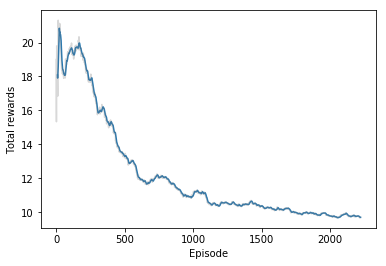

In [84]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

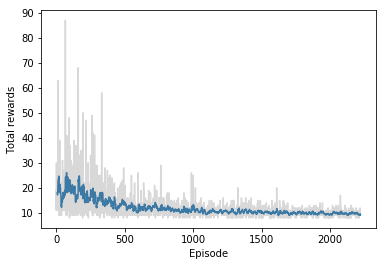

In [85]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.